# How to model light sources of different wavelengths on an opsin

How do we model dynamics for light of two different wavelengths, given photon flux $\phi_{\lambda_1}$ and $\phi_{\lambda_2}$?

Bansal et al., 2020 use a weighted sum of activation functions:

$$ G(\phi) = G(\phi_{\lambda_1}) + \varepsilon G(\phi_{\lambda_2}) $$

The problem is, these are sublinear functions, so adding them results in more activation than you'd actually expect.
In the extreme case, imagine two light sources that are just one nm apart in wavelength, with $\varepsilon \approx 1$.
Thus, if $\phi_{\lambda_1}=\phi_{\lambda_2}=\phi_{tot} / 2$ and $G(\phi) < 2G(\phi / 2)$, then $G(\phi_{tot}) \approx G(\phi_{\lambda_1}) + G(\phi_{\lambda_2}) \approx 2G(\phi_{tot}/2)$, which is clearly wrong.

A simpler approximation uses a weighted sum of fluxes:

$$ G(\phi) = G(\phi_{\lambda_1} + \varepsilon \phi_{\lambda_2}) $$

As we'll see below, that does yield a lower activation curve than the Bansal et al. approach.

$$
\newcommand{\phione}{\phi_{\lambda_1}}
\newcommand{\phitwo}{\phi_{\lambda_2}}
\newcommand{\varphitwo}{\varphi_{\lambda_2}}
\newcommand{\lr}[1]{\left(#1\right)}
$$

But the sum of fluxes approach does not follow exactly from the equations either.
What can we conclude from the sensitivity profiles reported in the literature, as such as that for vf-Chrimson from Mager et al, 2018?
The reported $\varepsilon$ value for 490 nm stimulation is 0.4:

![](img/orig/mager18.png)

I argue we would translate that as

$$
\begin{aligned}
G(\varphitwo) &= \varepsilon G(\phitwo) \\
\end{aligned}
$$

where $\varphitwo$ is the standard-wavelength equivalent ("effective flux") of $\phitwo$.

Demonstrating with $G_{a1}$, we solve for $\varphi$ in terms of $\phi$ and $\varepsilon$:
$$
\begin{aligned}
G_{a1}(\varphi) &= \varepsilon G_{a1}(\phi) \\
\frac{\varphi^p}{\varphi^p + \phi_m^p} &= \varepsilon \frac{\phi^p}{\phi^p + \phi_m^p} \\
\varphi^p\phi^p + \varphi^p\phi_m^p &= \varepsilon (\varphi^p + \phi_m^p) \phi^p \\
\lr{\phi^p+\phi_m^p-\varepsilon \phi^p} \varphi^p &= \varepsilon \phi^p \phi_m^p \\
\varphi^p &= \frac {\varepsilon \phi^p \phi_m^p} {(1-\varepsilon) \phi^p+\phi_m^p}\\
\varphi &= \lr{\frac {\varepsilon \phi^p \phi_m^p} {(1-\varepsilon) \phi^p+\phi_m^p}}^{1/p}\\
\end{aligned}
$$

Unfortunately, this doesn't yield a simple constant conversion factor.
We then compute our activation functions as

$$ G(\phione,\phitwo) = G(\phione + \varphitwo). $$

We'll now compare the three methods:

In [58]:
import numpy as np
import matplotlib.pyplot as plt

eps = 0.2

class Opsin4S:
    p = 0.833
    phim = 2.33e17
    k1 = 4.15
    Gf0 = .0373
    Gb0 = .0161
    Gd1 = .105
    k2 = 0.868
    kf = .0581
    kb = .063
    q = 1.94

    def Ga(self, phi, k):
        return k * phi**self.p / (phi**self.p + self.phim**self.p)
    def Ga1(self, phi):
        return self.Ga(phi, self.k1)
    def Ga2(self, phi):
        return self.Ga(phi, self.k2)
    def Gfb(self, phi, k, G0):
        return k * phi**self.q/(phi**self.q + self.phim**self.q) + G0
    def Gf(self, phi):
        return self.Gfb(phi, self.kf, self.Gf0)
    def Gb(self, phi):
        return self.Gfb(phi, self.kb, self.Gb0)
    def varphi(self, phi):
        return (
            eps * phi**self.p * self.phim**self.p \
            / ((1-eps) * phi**self.p + self.phim**self.p)
        ) ** (1/self.p)

class ChR2(Opsin4S):
    pass

class VfChrimson(Opsin4S):
    p = 1
    phim = 1.5e16
    k1 = 3
    Gf0 = .02
    Gb0 = 3.2e-3
    Gd1 = .37
    k2 = 0.2
    kf = .01
    kb = .01
    q = 1

class GtACR2(Opsin4S):
    p = 1
    phim = 2e17
    k1 = 40
    Gf0 = .001
    Gb0 = .003
    Gd1 = .017
    k2 = 20
    kf = .001
    kb = .005
    q = .1


First let's see what $\varphi$ looks like for ChR2:

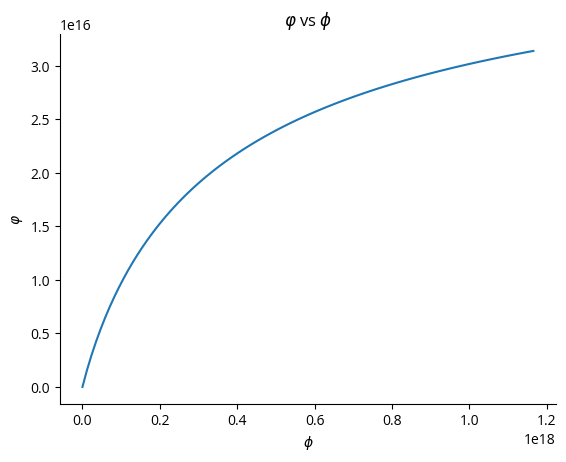

In [59]:
chr2 = ChR2()
phi = np.linspace(0, 5*chr2.phim, 100)
varphi = chr2.varphi(phi)
fig, ax = plt.subplots()
ax.plot(phi, varphi)
ax.set(xlabel=r'$\phi$', ylabel=r'$\varphi$', title=r'$\varphi$ vs $\phi$');

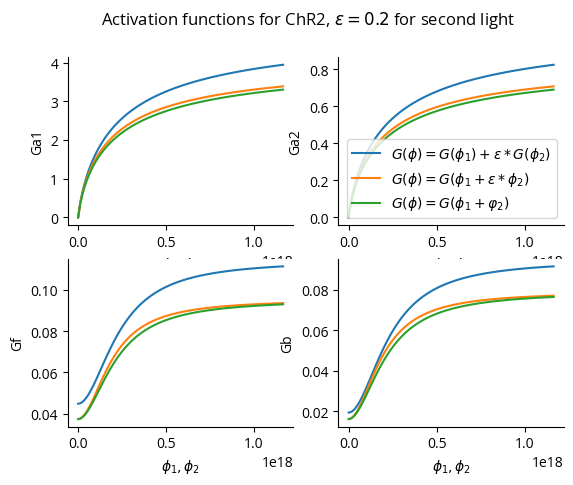

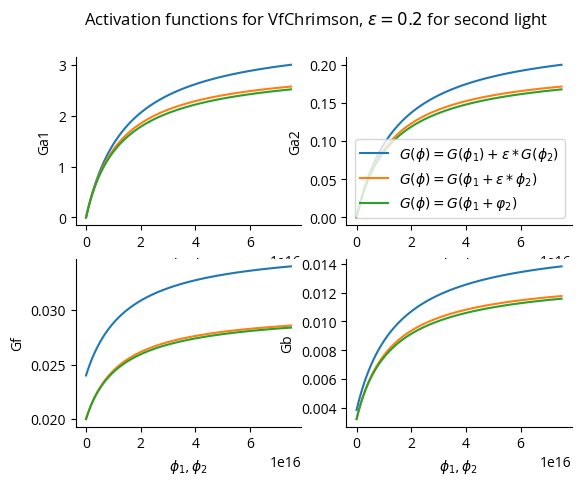

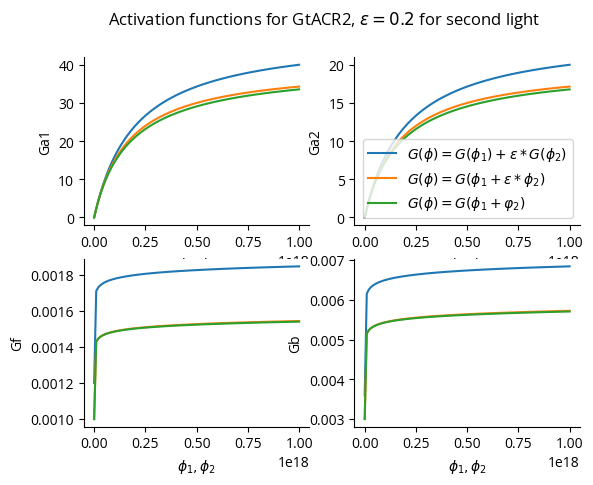

In [60]:
sum_constants = '$G(\phi) = G(\phi_1) + \\varepsilon*G(\phi_2)$'
sum_phi = '$G(\phi) = G(\phi_1 + \\varepsilon*\phi_2)$'
phi_convert = '$G(\phi) = G(\phi_1 + \\varphi_2)$'

for op in [ChR2(), VfChrimson(), GtACR2()]:
    fig, axs = plt.subplots(2, 2)
    phi = np.linspace(0, 5*op.phim, 100)
    varphi = op.varphi(phi)
    for fn, ax in zip([op.Ga1, op.Ga2, op.Gf, op.Gb], axs.flat):
        fn_name = fn.__name__
        # fig, ax = plt.subplots()
        ax.plot(phi, fn(phi) + eps * fn(phi), label=sum_constants)
        ax.plot(phi, fn(phi + eps * phi), label=sum_phi)
        ax.plot(phi, fn(phi+varphi), label=phi_convert)
        ax.set(xlabel='$\phi_1, \phi_2$', ylabel=f'{fn_name}')
        # fig.legend(loc='center right')
    axs[0, 1].legend(loc='lower right')
    fig.suptitle(f'Activation functions for {type(op).__name__}, $\epsilon={eps}$ for second light');

Now we'll try some of the three-state models from Bansal et al., 2020:

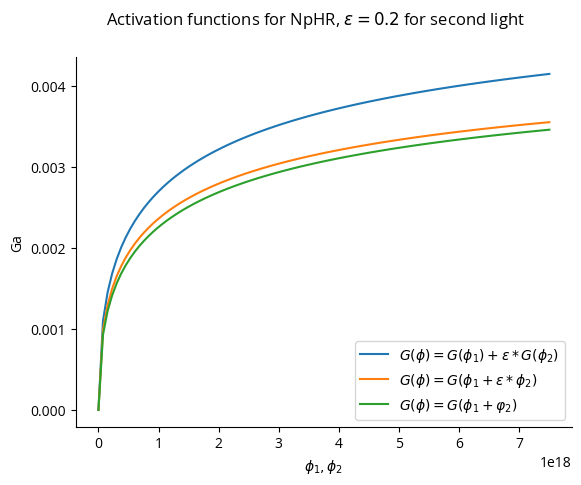

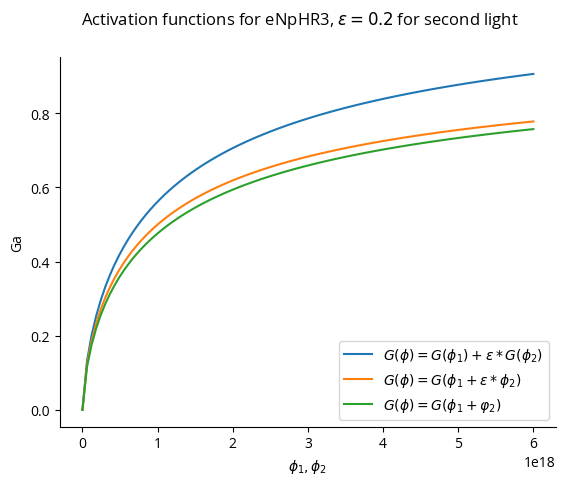

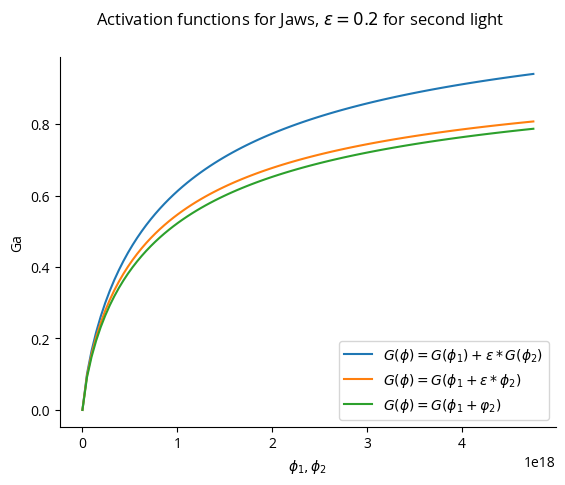

In [61]:
class Opsin3S:
    p = 0.5
    q = 0.2
    phim = 1.5e18
    ka = .005
    # kr = 4.15

    def Ga(self, phi):
        return self.ka * phi**self.p / (phi**self.p + self.phim**self.p)
    # def Gr(self, phi):
    #     return self.kr * phi**self.q / (phi**self.q + self.phim**self.q)
    def varphi(self, phi):
        return (
            eps * phi**self.p * self.phim**self.p \
            / ((1-eps) * phi**self.p + self.phim**self.p)
        ) ** (1/self.p)

class NpHR(Opsin3S):
    pass

class eNpHR3(Opsin3S):
    p = .7
    q = .1
    phim = 1.2e18
    ka = 1

class Jaws(Opsin3S):
    p = .8
    q = 1
    phim = .95e18
    ka = 1

for op in [NpHR(), eNpHR3(), Jaws()]:
    fig, ax = plt.subplots()
    phi = np.linspace(0, 5*op.phim, 100)
    varphi = op.varphi(phi)
    fn = op.Ga
    fn_name = 'Ga'
    ax.plot(phi, fn(phi) + eps * fn(phi), label=sum_constants)
    ax.plot(phi, fn(phi + eps * phi), label=sum_phi)
    ax.plot(phi, fn(phi+varphi), label=phi_convert)
    ax.set(xlabel='$\phi_1, \phi_2$', ylabel=f'{fn_name}')
    ax.legend(loc='lower right')
    fig.suptitle(f'Activation functions for {type(op).__name__}, $\epsilon={eps}$ for second light');

## Converting from an equal photon flux to an equal power density spectrum

Some action spectra are measured with equal power density/pulse width across wavelengths, while others are reported with equal photon flux.
We store ours as equal power density spectra since they seem to be more common and allow for the opsin model to use both accurate power density and photon flux values.
We use $\epsilon$ to represent sensitivity relative to the peak-sensitivity wavelength, $\epsilon_\phi$ and $\epsilon_P$ representing the equal photon flux and power density versions, respectively.

For a given wavelength $\lambda$,

$$ \epsilon = \frac{G(\varphi_\lambda)}{G(\phi)} $$
$$ \epsilon = \frac{G_\lambda}{G(\phi)} $$

We let $G_\lambda$ represent the response at wavelength $\lambda$, while $G(\phi)$ represents the response at the peak wavelength for the same flux $\phi$.

We will assume $G$ is a linear function, as above, using $C$ to represent a constant.

\begin{gathered}
\epsilon_\phi = \frac{G_\lambda}{G(\phi)} & \epsilon_P = \frac{G_\lambda}{G(\phi)} \\
\epsilon_\phi = \frac{G_\lambda}{C\phi} & \epsilon_P = \frac{G_\lambda}{C\phi} \\
\end{gathered}

We now plug in either equal photon flux or irradiance (power density):

\begin{gathered}
\epsilon_\phi = \frac{G_\lambda}{C\phi_\text{const}} & \epsilon_P = \frac{G_\lambda}{CI_\text{const}/e_\text{photon}} \\
  & \epsilon_P = \frac{G_\lambda}{CI_\text{const} \lambda} \\
\epsilon_\phi = \frac{G_\lambda}{C} & \epsilon_P = \frac{G_\lambda}{C\lambda} \\
\end{gathered}

$$ C\epsilon_\phi = C\lambda\epsilon_P = G_\lambda $$
$$ \color{Green}\epsilon_P = C \frac{\epsilon_\phi}{\lambda} $$

So we can convert from $\epsilon_\phi$ to $\epsilon_P$ by dividing by $\lambda$ and normalizing.